In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats

## 1D

The dynamics is defined by the following ODE:
$$\frac{dx}{dt} = \frac{1}{p(x)}.$$
Then, the evolution flow is
$$g(x_0,t) = F^{-1}\bigg(t+F(x_0)\bigg)$$
Note, that putting the whole dynamics on a torus is equivalent to
$$g(x_0,t) = F^{-1}\bigg((t+F(x_0)) \text{mod} 1\bigg)$$

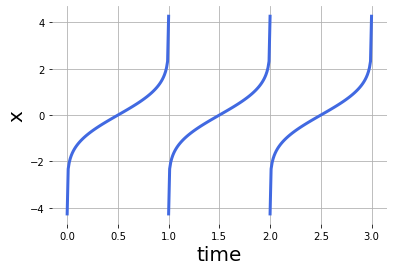

In [92]:
figsize(6,4)
u = np.linspace(0.0+1e-5,1.0-1e-5,100)
for i in range(3):
    plt.plot(u+i, stats.norm.ppf(u), lw=3, c='royalblue')
plt.box(False)
plt.xlabel('time', size=20)
plt.ylabel('x', size=20)
plt.grid()

## Simulation via integrated dynamics

We begin with discretizing the integrated dynamics. That is
$$x' = F^{-1}\bigg((dt+F(x)) \text{mod} 1\bigg),$$
where $dt$ is the step size of our discrete scheme. Note that to densely cover the $[0,1]$ interval we must take irrational $dt$. 
Of course we cannot put irrational number into float32, that is why we just take the float32 approximation of $\sqrt{2}$, and then consider different $dt = k\sqrt{2}$, where $k < 1$ is the scale factor. Note that the choice of $\sqrt{2}$ as a maximal step size is nice since we are interested only in $dt \in [0,1/2]$, but we don't want to be too close to $1/2$.

### sampler

In [86]:
def sample_integrated(x0, n, dt):
    u0 = stats.norm.cdf(x0)
    u = (u0 + np.arange(n)*dt) % 1.0
    return stats.norm.ppf(u)

### check
checking the histogram of samples starting from $x_0=-10$

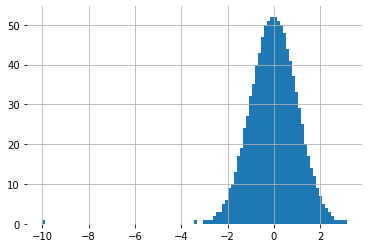

In [90]:
figsize(6,4)
samples = sample_integrated(-10, 1000,np.sqrt(2))
plt.hist(samples, bins=100)
plt.box(False)
plt.grid()

### convergence for different k

now we check the absolute error for different number of samples (averaging over the initial point $x_0$).

In [155]:
def get_estimates(max_samples, n_tries, scales):
    mean_estimates = np.zeros([n_tries, len(scales), max_samples])
    var_estimates = np.zeros([n_tries, len(scales), max_samples-1])
    for try_id in range(n_tries):
        x0 = np.random.normal()
        for k_id in range(len(scales)):
            k = scales[k_id]
            dt = k*np.sqrt(2)
            samples = sample_integrated(x0, max_samples,dt)
            mu = np.cumsum(samples)/np.arange(1,n+1)
            sigma2 = np.repeat(samples[np.newaxis,:], max_samples, 0) - mu[np.newaxis,:]
            sigma2 = np.diag(np.cumsum(sigma2**2, axis=1))[1:]/np.arange(1,n)
            mean_estimates[try_id, k_id,:] = mu
            var_estimates[try_id, k_id,:] = sigma2
    return mean_estimates, var_estimates

In [156]:
max_samples = 1000
n_tries = 1000
scales = np.logspace(-4,0,5)
mean_estimates, var_estimates = get_estimates(max_samples, n_tries, scales)

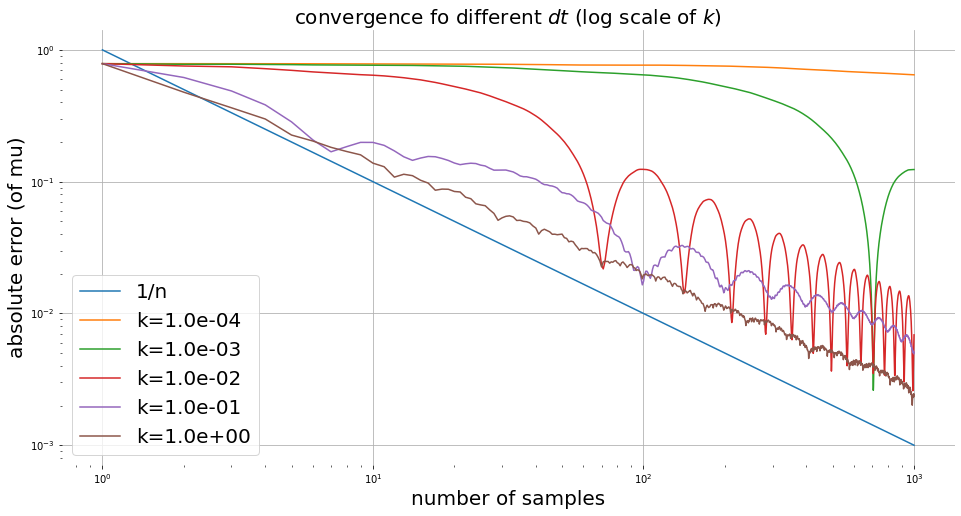

In [157]:
figsize(16,8)
plt.plot(np.arange(1,n+1), 1/np.arange(1,n+1), label='1/n')
for k_id in range(len(scales)):
    plt.plot(np.arange(1,n+1), np.mean(np.abs(mean_estimates[:,k_id,:]), axis=0), 
             label=r'k=%.1e' % scales[k_id])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of mu)', size=20)
plt.title(r'convergence for different $dt$ (log scale of $k$)', size=20)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()

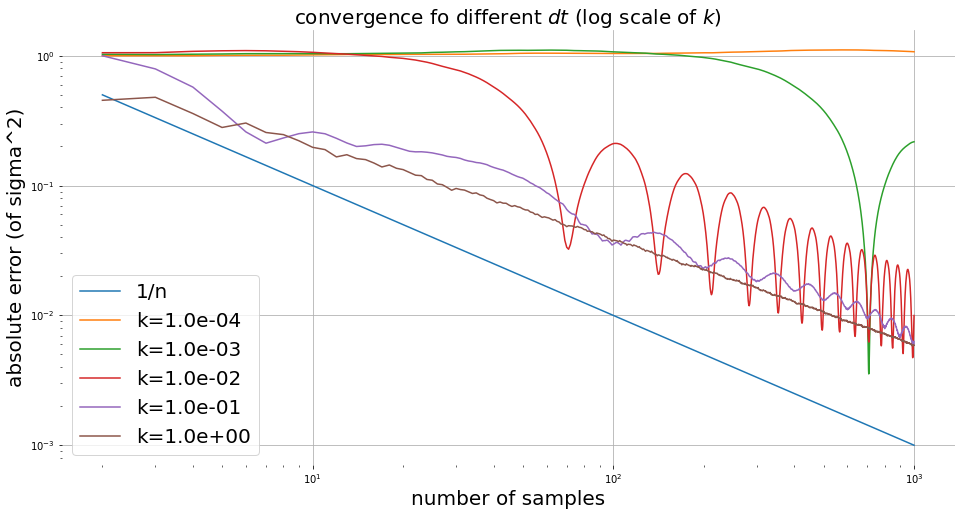

In [158]:
figsize(16,8)
plt.plot(np.arange(2,n+1), 1/np.arange(2,n+1), label='1/n')
for k_id in range(len(scales)):
    plt.plot(np.arange(2,n+1), np.mean(np.abs(var_estimates[:,k_id,:]-1.0), axis=0), 
             label=r'k=%.1e' % scales[k_id])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of sigma^2)', size=20)
plt.title(r'convergence for different $dt$ (log scale of $k$)', size=20)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()

In [159]:
max_samples = 1000
n_tries = 1000
scales = 1./np.linspace(1,5,5)

mean_estimates, var_estimates = get_estimates(max_samples, n_tries, scales)

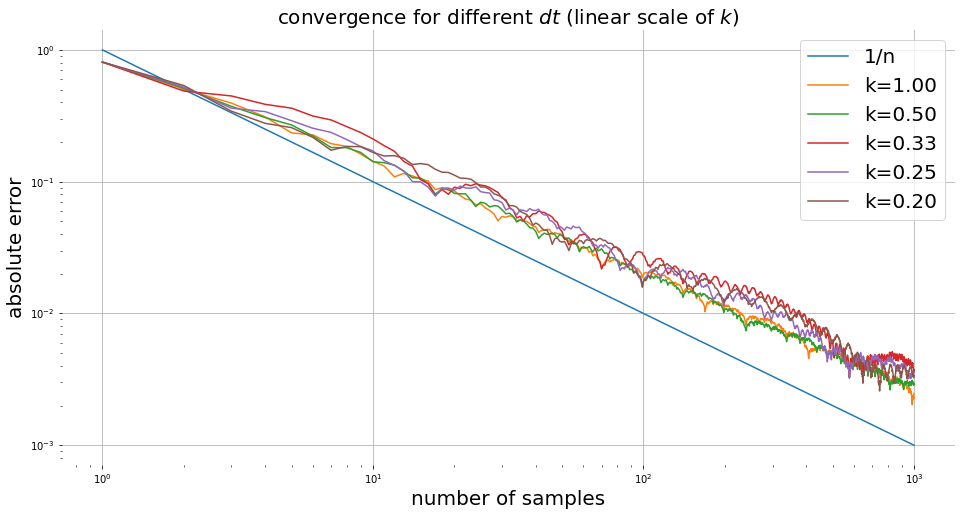

In [162]:
figsize(16,8)
plt.plot(np.arange(1,n+1), 1/np.arange(1,n+1), label='1/n')
for k_id in range(len(scales)):
    plt.plot(np.arange(1,n+1), np.mean(np.abs(mean_estimates[:,k_id,:]), axis=0), 
             label=r'k=%.2f' % scales[k_id])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error', size=20)
plt.title(r'convergence for different $dt$ (linear scale of $k$)', size=20)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()

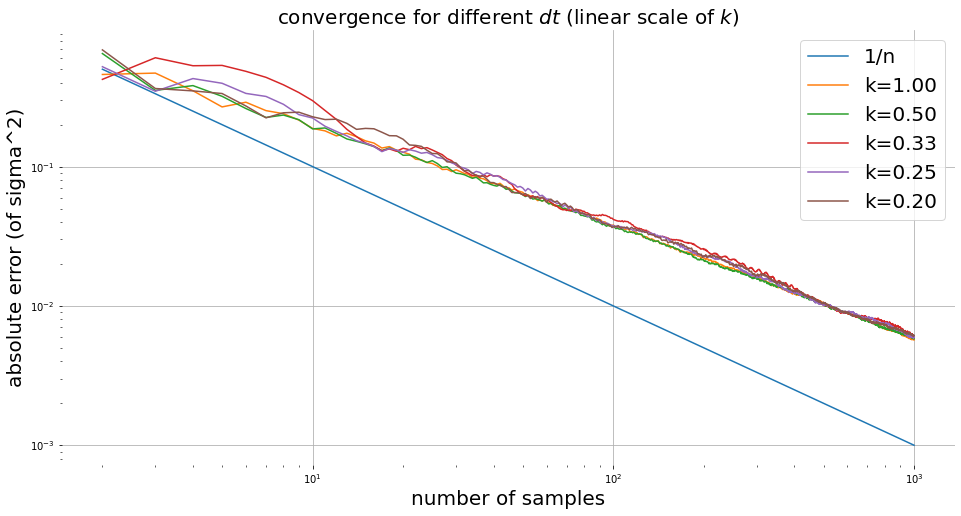

In [163]:
figsize(16,8)
plt.plot(np.arange(2,n+1), 1/np.arange(2,n+1), label='1/n')
for k_id in range(len(scales)):
    plt.plot(np.arange(2,n+1), np.mean(np.abs(var_estimates[:,k_id,:]-1.0), axis=0), 
             label=r'k=%.2f' % scales[k_id])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of sigma^2)', size=20)
plt.title(r'convergence for different $dt$ (linear scale of $k$)', size=20)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()

## Simulation via differential equation

Now we try to sample from the same distribuion via the differential equation not relying on the knowledge of CDF and its inverse. That is, we first map the whole distribution $p(x)$ via tanh, then we sample $y = \tanh(x)$ by discretizing the equation in the most naive way:
$$y(t+dt) = y(t) + dt \frac{1}{q(x(t))}.$$
Finally, we map samples in $y$-space back to the original space: $x = \tanh^{-1}(y) = \frac{1}{2}\log\big(\frac{1+y}{1-y}\big)$. We analyse the convergence for $dt = \{10^{-1},10^{-2},10^{-3},10^{-4}\}$.

### sampler

In [250]:
def f(x):
    return np.tanh(x)

def f_inv(y):
    return 0.5*(np.log(1+y)-np.log(1-y))

def sample_diffeq(x0, n, dt):
    def q(y):
        return stats.norm.pdf(f_inv(y))/(1-y**2)
    samples = np.zeros(n)
    log_jacobian = np.zeros(n)
    samples[0] = f(x0)
    for i in range(n-1):
        next_sample = (samples[i] + dt/q(samples[i]))
        next_sample = (next_sample-1)%2-1
        samples[i+1] = next_sample
    samples = f_inv(samples)
    return samples

### check

checking the sampler for $dt=10^{-2}$ and $x_0 = -10.0$

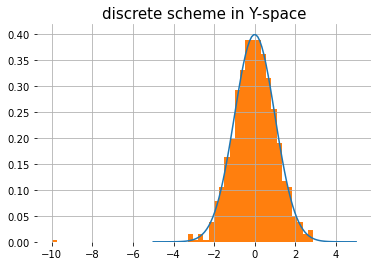

In [310]:
figsize(6,4)
y = np.linspace(-5,5,100)
plt.plot(y,stats.norm.pdf(y))

samples = sample_diffeq(-10.0, 1000, 1e-2)
plt.hist(samples, bins=50, density=True)
plt.title('discrete scheme in Y-space', size=15)
plt.box(False)
plt.grid()

note that the same scheme in the original space require agressive truncation of the density ($[-3,3]$ in the example), and still behaves worse for the same step size.

In [307]:
def sample_diffeq_x(x0, n, dt):
    samples = np.zeros(n)
    samples[0] = x0
    for i in range(n-1):
        next_sample = (samples[i] + dt/stats.norm.pdf(samples[i]))
        next_sample = (next_sample-3)%6-3
        samples[i+1] = next_sample
    return samples

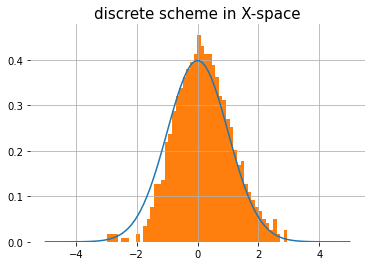

In [311]:
figsize(6,4)
y = np.linspace(-5,5,100)
plt.plot(y,stats.norm.pdf(y))

samples = sample_diffeq_x(-0.1, 1000, 1e-2)
plt.hist(samples, bins=50, density=True)
plt.title('discrete scheme in X-space', size=15)
plt.box(False)
plt.grid()

### convergence for different $dt$

In [271]:
def get_estimates_diffeq(max_samples, n_tries, scales):
    mean_estimates = np.zeros([n_tries, len(scales), max_samples])
    var_estimates = np.zeros([n_tries, len(scales), max_samples-1])
    for try_id in range(n_tries):
        x0 = np.random.normal()
        for k_id in range(len(scales)):
            k = scales[k_id]
            dt = k*np.sqrt(2)
            samples = sample_diffeq(x0, max_samples, dt)
            mu = np.cumsum(samples)/np.arange(1,n+1)
            sigma2 = np.repeat(samples[np.newaxis,:], max_samples, 0) - mu[np.newaxis,:]
            sigma2 = np.diag(np.cumsum(sigma2**2, axis=1))[1:]/np.arange(1,n)
            mean_estimates[try_id, k_id,:] = mu
            var_estimates[try_id, k_id,:] = sigma2
    return mean_estimates, var_estimates

In [272]:
max_samples = 1000
n_tries = 100
scales = np.logspace(-4,-1,4)

mean_estimates, var_estimates = get_estimates_diffeq(max_samples, n_tries, scales)

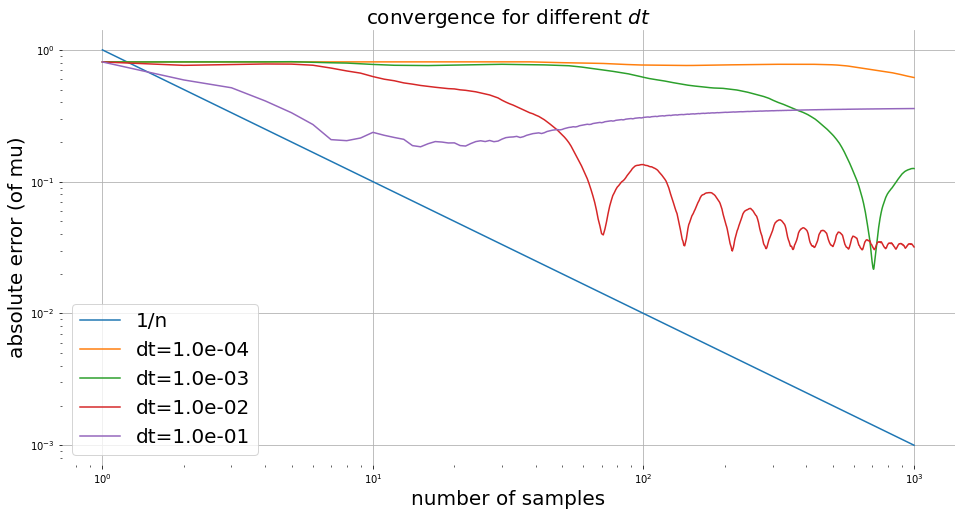

In [279]:
figsize(16,8)
plt.plot(np.arange(1,n+1), 1/np.arange(1,n+1), label='1/n')
for k_id in range(len(scales)):
    plt.plot(np.arange(1,n+1), np.mean(np.abs(mean_estimates[:,k_id,:]), axis=0), 
             label=r'dt=%.1e' % scales[k_id])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of mu)', size=20)
plt.title(r'convergence for different $dt$', size=20)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()

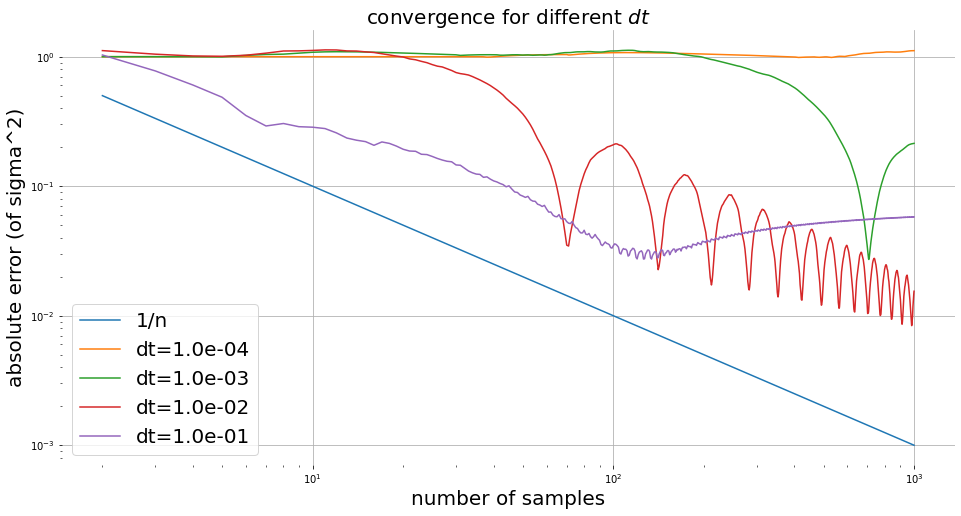

In [276]:
figsize(16,8)
plt.plot(np.arange(2,n+1), 1/np.arange(2,n+1), label='1/n')
for k_id in range(len(scales)):
    plt.plot(np.arange(2,n+1), np.mean(np.abs(var_estimates[:,k_id,:]-1.0), axis=0), 
             label=r'dt=%.1e' % scales[k_id])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of sigma^2)', size=20)
plt.title(r'convergence for different $dt$', size=20)
plt.box(False)
plt.legend(fontsize=20)
plt.grid()